In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(7, 5) (1, 5) (2, 5)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
pipe_lr = Pipeline([("pre", pre), ("clf", logreg)])

pipe_lr.fit(X_train, y_train)
y_val_pred = pipe_lr.predict(X_val)
print("Baseline (LogReg) F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline (LogReg) F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1

    accuracy                          1.000         1
   macro avg      1.000     1.000     1.000         1
weighted avg      1.000     1.000     1.000         1



In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
)
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])

pipe_rf.fit(X_train, y_train)
y_val_rf = pipe_rf.predict(X_val)
print("RandomForest F1(val):", f1_score(y_val, y_val_rf, average="macro"))

RandomForest F1(val): 1.0


In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}
gs = GridSearchCV(pipe_rf, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV F1:", gs.best_score_)

best_rf = gs.best_estimator_
y_val_best = best_rf.predict(X_val)
print("Best RF F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best CV F1: 1.0
Best RF F1(val): 1.0


F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Confusion matrix (test):
[[1 0]
 [0 1]]
ROC-AUC(test): 1.0


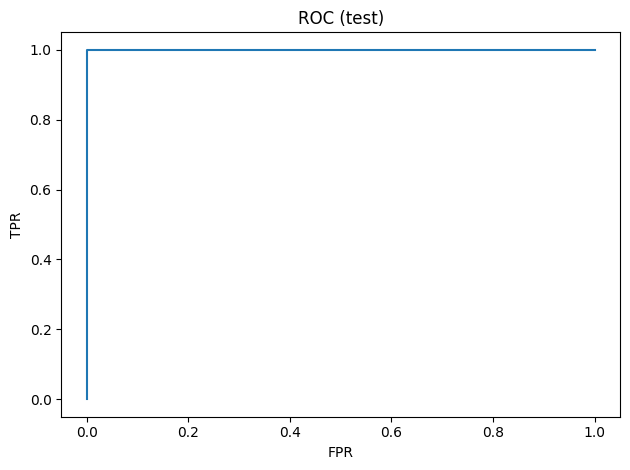

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

final_model = best_rf  # atau pipe_lr jika baseline lebih baik
y_test_pred = final_model.predict(X_test)

print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (jika ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

In [6]:
import joblib
joblib.dump(final_model, "model.pkl")
print("Model tersimpan ke model.pkl")

Model tersimpan ke model.pkl


In [ ]:
from flask import Flask, request, jsonify
import joblib, pandas as pd
from threading import Thread

app = Flask(__name__)
MODEL = joblib.load("model.pkl")

@app.route("/")
def home():
    return "✅ Server Flask aktif! Gunakan endpoint POST /predict untuk prediksi."

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)
    X = pd.DataFrame([data])
    yhat = MODEL.predict(X)[0]
    proba = None
    if hasattr(MODEL, "predict_proba"):
        proba = float(MODEL.predict_proba(X)[:, 1][0])
    return jsonify({"prediction": int(yhat), "proba": proba})

def run_flask():
    app.run(port=5000, debug=False, use_reloader=False)

if 'flask_thread' not in globals():
    from threading import Thread
    flask_thread = Thread(target=run_flask)
    flask_thread.start()
    print("🚀 Flask server berjalan di http://127.0.0.1:5000/")


🚀 Flask server berjalan di http://127.0.0.1:5000/
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [24/Oct/2025 23:29:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 23:29:16] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Oct/2025 23:29:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 23:29:18] "GET /favicon.ico HTTP/1.1" 404 -
